In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

## Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [44]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit

## Область работы 2 (поиск  модели .... )

In [54]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# оставляйте свои комментарии и разъяснения
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 
path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

In [55]:
train = pd.read_csv(path_train)

In [56]:
train[train.duplicated()] #Проверка на наличие дубликатов

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [57]:
train['quality'] = train['quality'].apply(lambda x: 1 if x >= 7 else 0)

### Для начала построим лучшую модель без обработки данных

#### KNN

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = 'quality'), train['quality'], 
                                                     test_size=0.3)

In [9]:
param_grid = {
    'leaf_size' : np.arange(1,50),
    'n_neighbors': np.arange(1,50),     # Количество соседей
    'weights': ['distance'],  # Веса соседей
    'p': [1]                      
}

In [10]:
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='precision')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'p': [1], 'weights': ['distance']},
             scoring='precision')

In [11]:
grid_search.best_params_

{'leaf_size': 1, 'n_neighbors': 31, 'p': 1, 'weights': 'distance'}

In [12]:
model_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(leaf_size = 1, n_neighbors = 10, p=1, weights='distance'))
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
#y_pred = np.where(y_pred >= 7, 1, 0)
#y_test = y_test.apply(lambda x: 1 if x >= 7 else 0)

In [13]:
from sklearn.metrics import recall_score, precision_score, f1_score

print('precision: ', precision_score(y_test,  y_pred))
print('recall:    ', recall_score(y_test,  y_pred))
print('f1:        ', f1_score(y_test,  y_pred))
print('roc_auc_score:', roc_auc_score(y_pred,y_test))

precision:  0.6777777777777778
recall:     0.6559139784946236
f1:         0.6666666666666666
roc_auc_score: 0.7442143326758712


In [14]:
# Создайте объект StratifiedKFold с параметром shuffle=True
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Затем передайте этот объект в функцию cross_val_score
cv_scores = cross_val_score(model_knn, X_test, y_test, cv=cv, scoring="precision")

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean Precision = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.5000
	0.6667
	0.7692
	0.8125
	0.6471
	0.7222
	0.5455
	0.6957
	0.7500
	0.5652
Mean Precision = 0.6674


#### Логистическая регрессия

In [15]:
# Создайте список всех возможных комбинаций солверов и штрафов
pipe = Pipeline([('preprocessing', MinMaxScaler()),
('clf', LogisticRegression())])

scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler() ]
param_grid =[
{'preprocessing': scaling,'clf__penalty': ['l2'],
'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'],
'clf__C':  np.arange(1,100, 0.5)},
{'preprocessing': scaling,'clf__penalty': ['l1'],
'clf__solver': ['liblinear'],
'clf__C': np.arange(1,100, 0.5)},
{'preprocessing': scaling,'clf__penalty': ['none'],
'clf__solver': ['lbfgs','newton-cg'],}
]

# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [10,100]
# param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5)
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, scoring='precision')

In [16]:
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.677166 using {'clf__C': 1.5, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'preprocessing': MinMaxScaler()}


In [17]:
best_model = make_pipeline(MinMaxScaler(),  LogisticRegression(solver='liblinear', penalty='l2', C = 2.0,
                                                               ))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
#y_pred = np.where(y_pred >= 7, 1, 0)
#y_test = y_test.apply(lambda x: 1 if x >= 7 else 0)

In [18]:
print('precision: ', precision_score(y_test,  y_pred))
print('recall:    ', recall_score(y_test,  y_pred))
print('f1:        ', f1_score(y_test,  y_pred))
print('roc_auc_score:', roc_auc_score(y_pred,y_test))

precision:  0.743421052631579
recall:     0.6075268817204301
f1:         0.6686390532544378
roc_auc_score: 0.7719837503595054


In [19]:
# Создайте объект StratifiedKFold с параметром shuffle=True
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Затем передайте этот объект в функцию cross_val_score
cv_scores = cross_val_score(best_model, X_test, y_test, cv=cv, scoring="precision")

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean Precision = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.7059
	0.6429
	0.6842
	0.6923
	0.8667
	0.7143
	0.5714
	0.7619
	0.7059
	0.7500
Mean Precision = 0.7095


### Теперь проведем предобработку данных

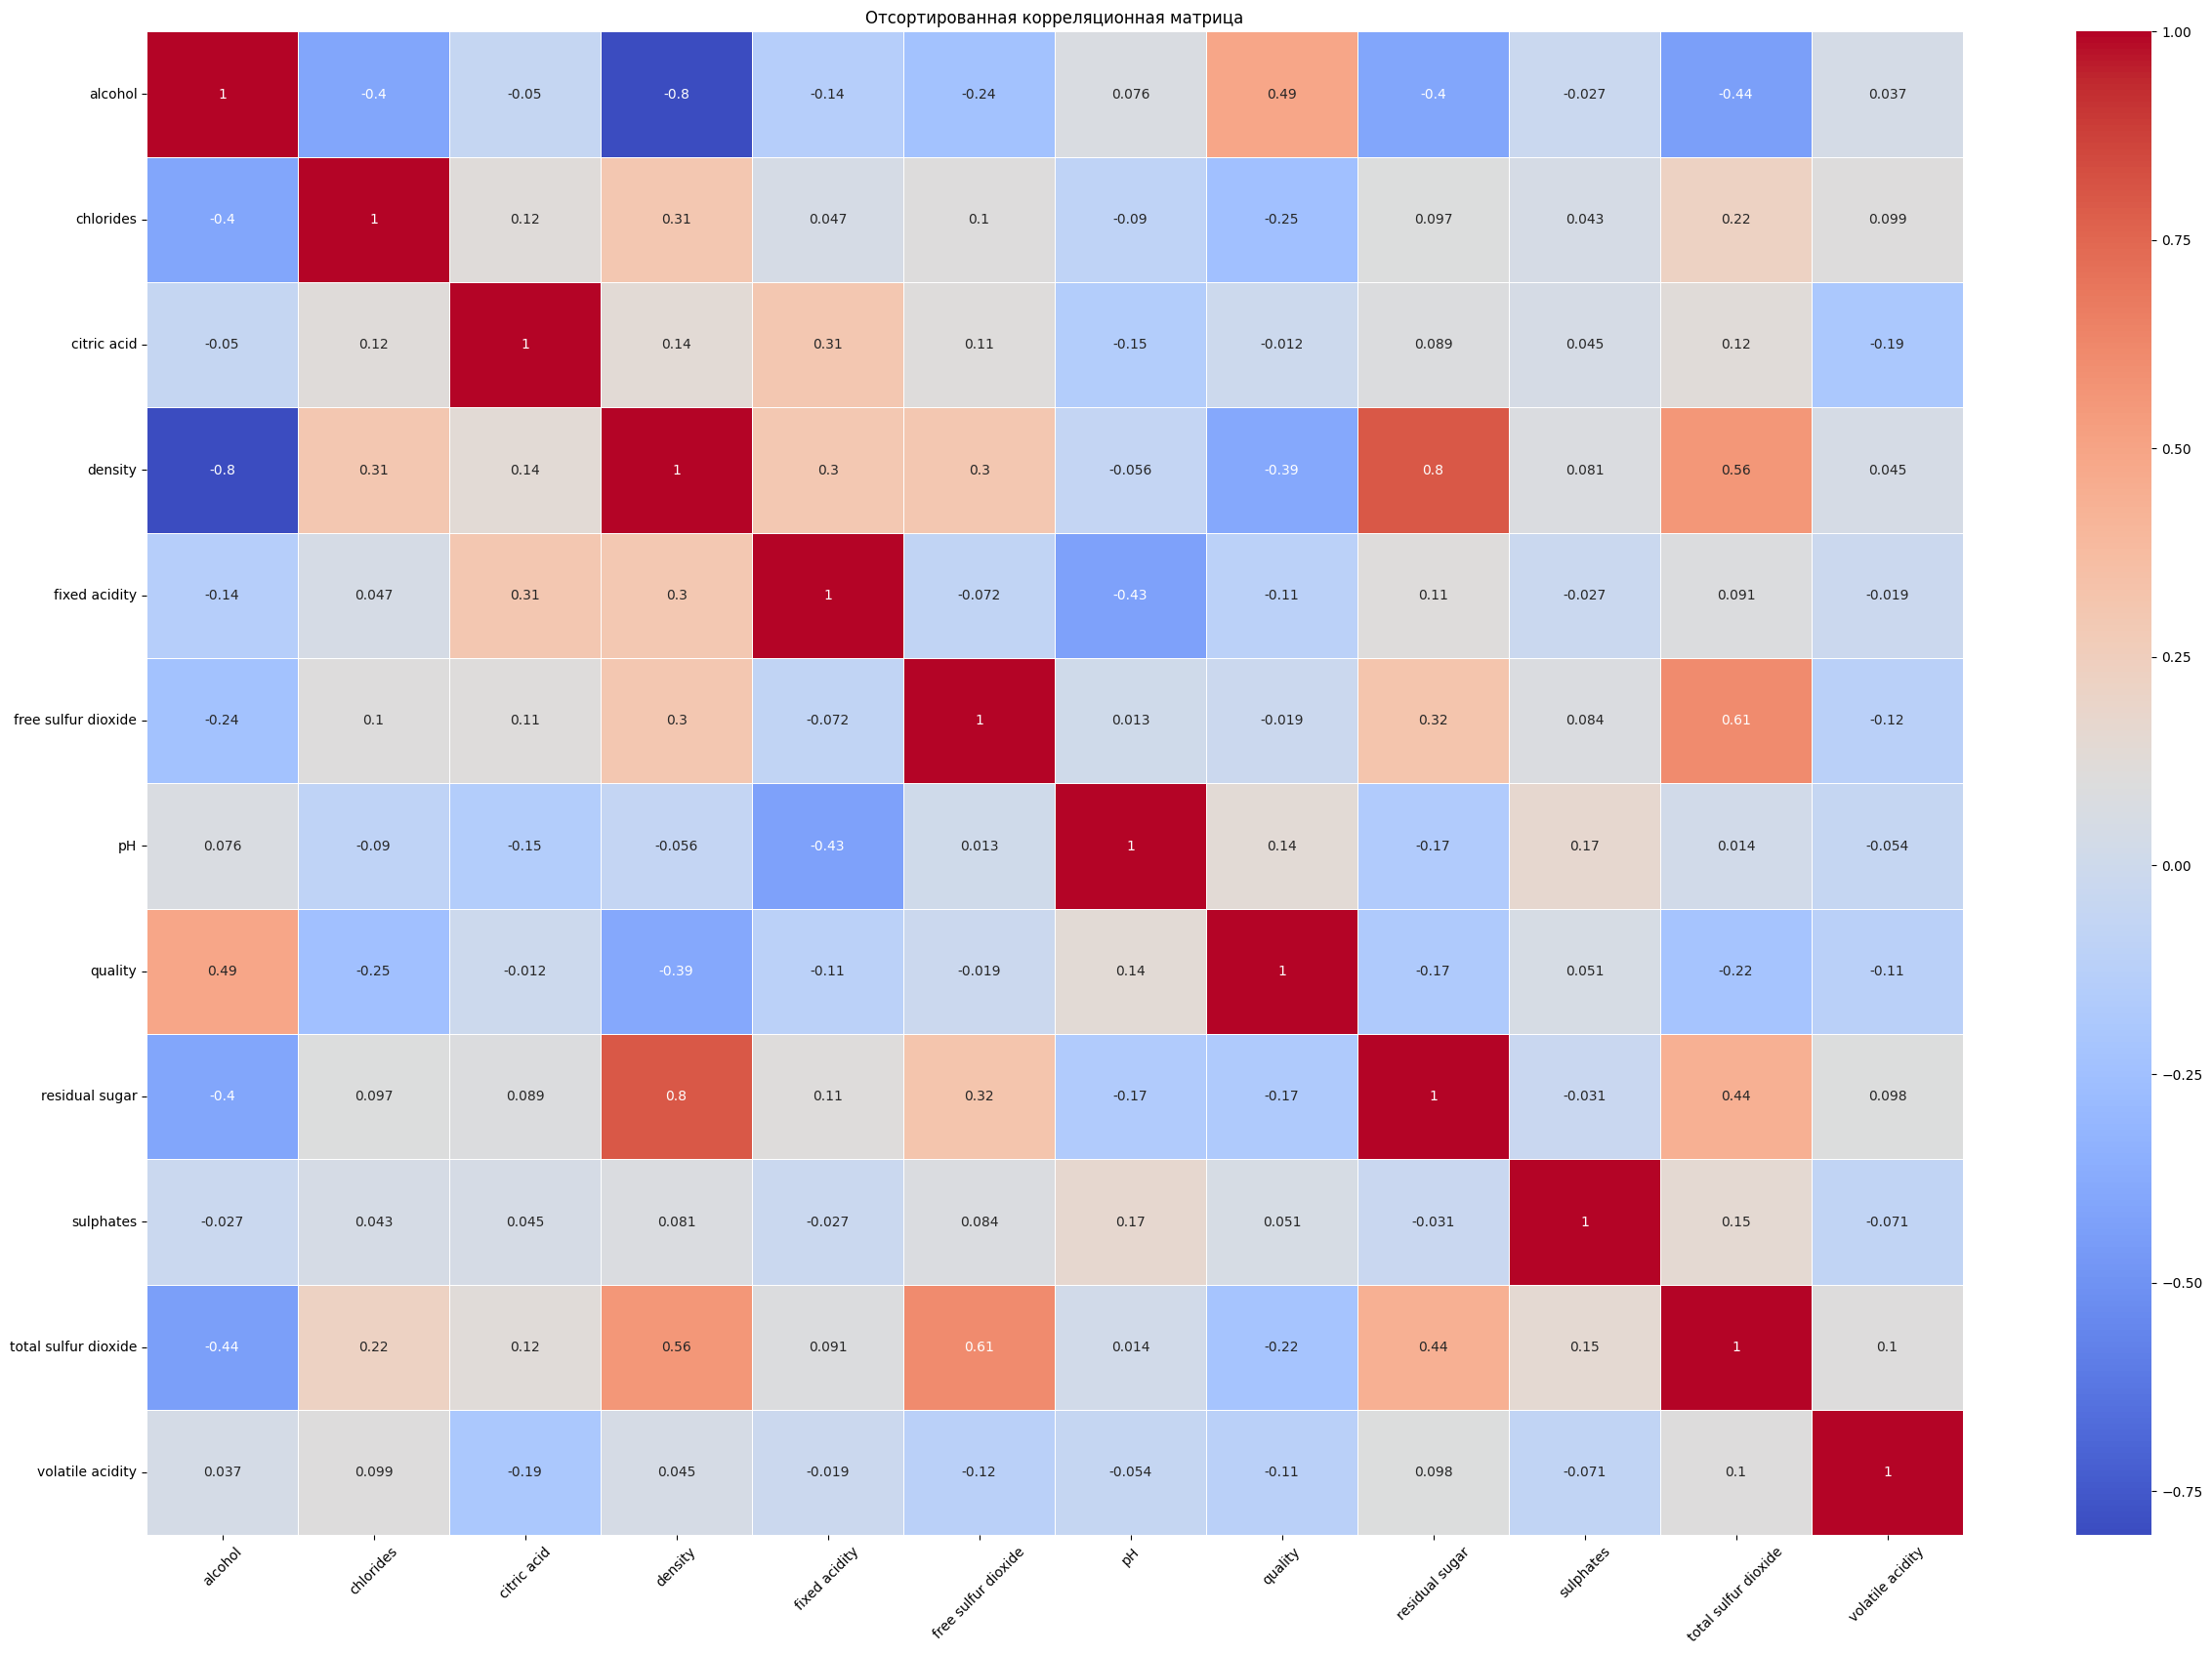

In [58]:
correlation_matrix = train.select_dtypes(include=['float64', 'int64']).corr()
# Получите имена столбцов, отсортированные по алфавиту
sorted_columns = sorted(correlation_matrix.columns)

# Создайте отсортированную корреляционную матрицу
sorted_correlation_matrix = correlation_matrix.reindex(sorted_columns).sort_index(axis=1)

# Создайте тепловую карту для отсортированной корреляционной матрицы
plt.figure(figsize=(30, 20))
sns.heatmap(sorted_correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)

# Настройки графика
plt.title("Отсортированная корреляционная матрица")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Корреляционная матрица показывает, что есть столбец "density", который имеет высокую корреляцию с двумя другими столбцами. Но прогонка модели без этого столбца показала результат хуже, поэтому оставим как есть

#### Выбросы

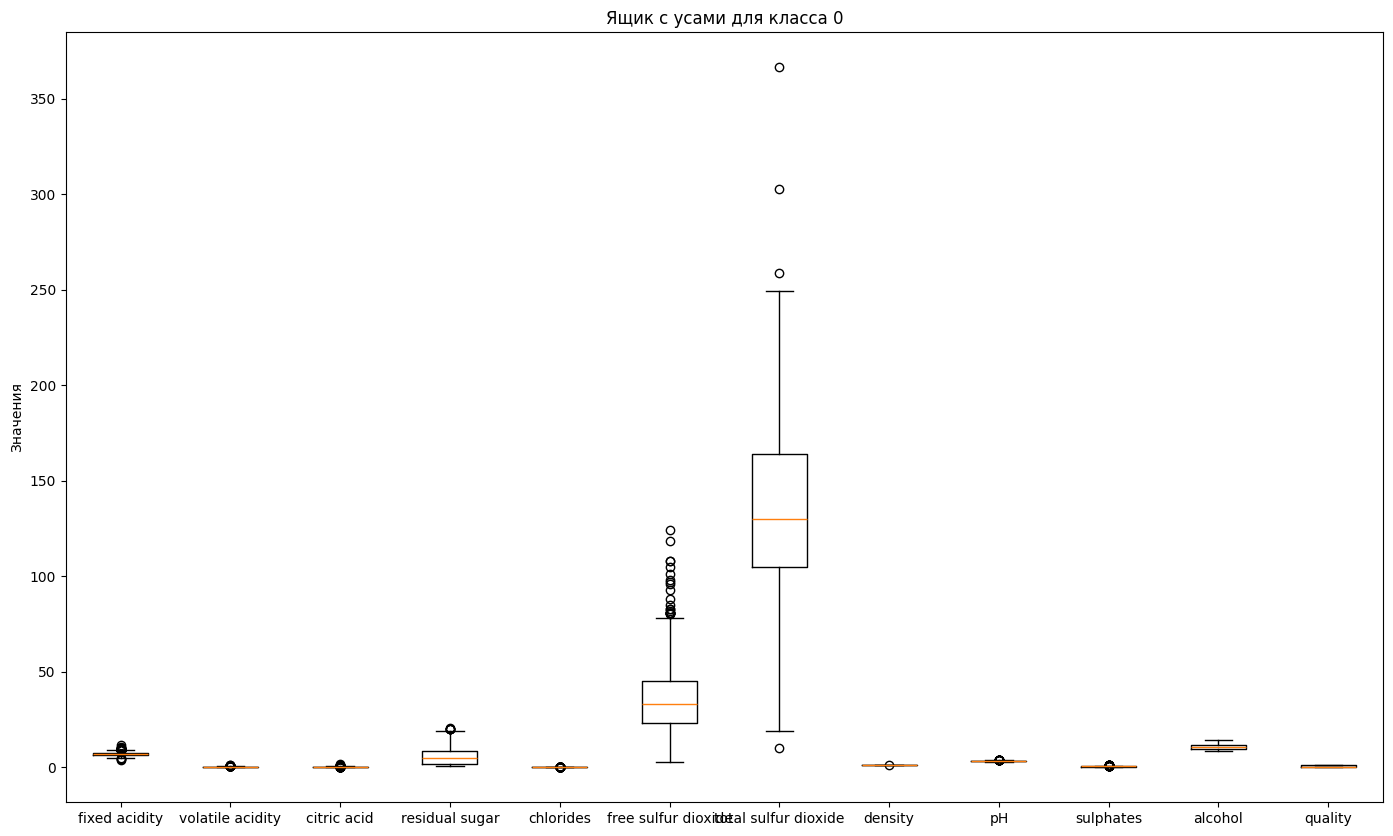

In [59]:
import matplotlib.pyplot as plt

# Set the figure size first
plt.figure(figsize=(17, 10))

# Create a boxplot for the columns in the DataFrame 'train'
plt.boxplot(train.values, labels = train.columns)

# Add a title and axis labels
plt.title('Ящик с усами для класса 0')
plt.ylabel('Значения')

# Show the plot
plt.show()


Видим, в столбце total sulfur dioxide выбросы сверху и снизу. Также эти выбросы есть и в других столбцах.
Но я обнаружил интересную взаимосвзяь: в столбцах, в которых много точек за границами ухудшают модель, в отличии от столбцов, где таких выбросов малое количество. Продемонстрирую на графике


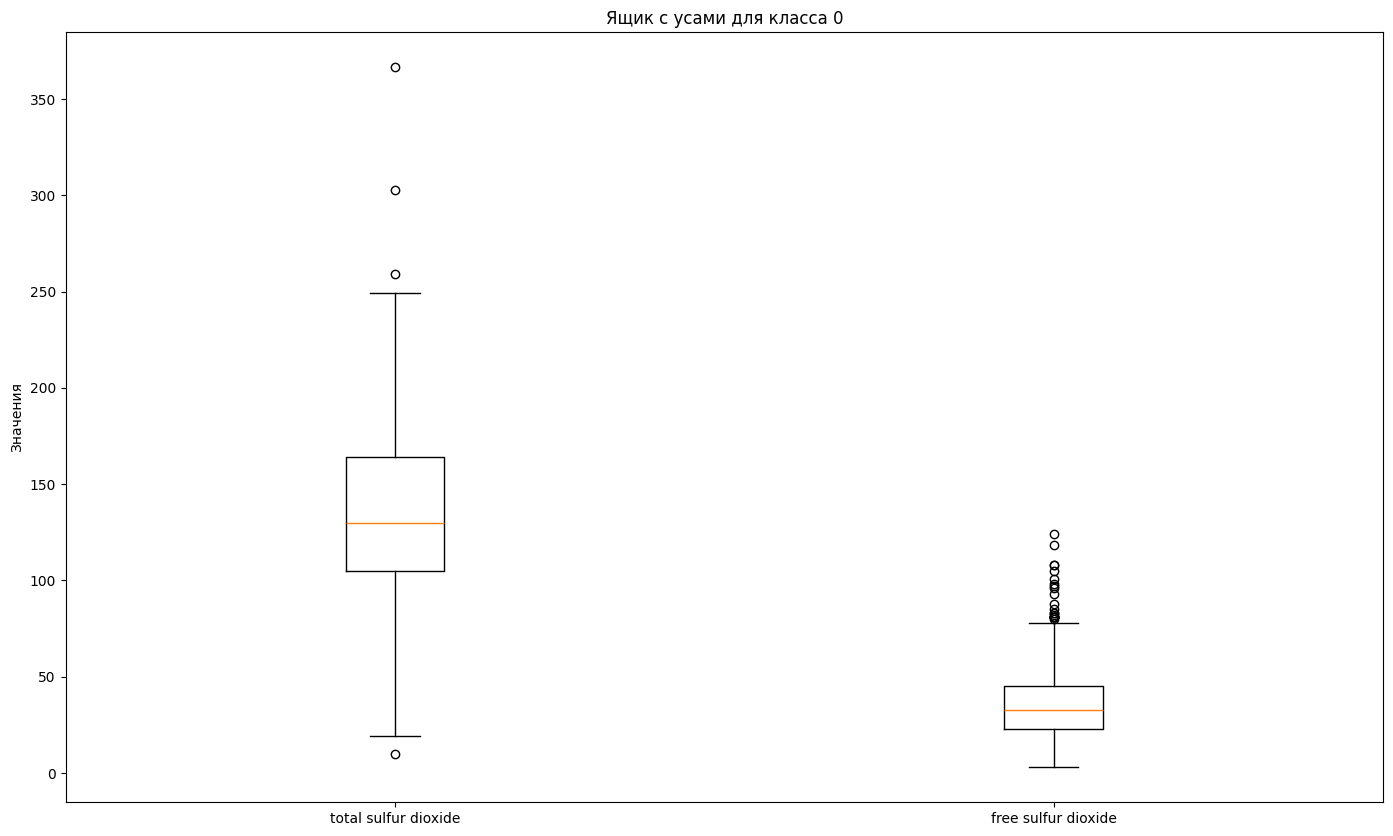

In [60]:
import matplotlib.pyplot as plt

# Set the figure size first
plt.figure(figsize=(17, 10))

# Create a boxplot for the columns in the DataFrame 'train'
plt.boxplot(train[['total sulfur dioxide', 'free sulfur dioxide']].values,labels =['total sulfur dioxide', 'free sulfur dioxide'] )

# Add a title and axis labels
plt.title('Ящик с усами для класса 0')
plt.ylabel('Значения')

# Show the plot
plt.show()


В 1 ящике есть лишь несколько выбросов. Во 2 уже их очень много. У меня догадка, почему удаление в 1 столбце помогает, а во втором - нет.
Все дело в том, что во втором ящике, где много выбросов - это на самом деле выбросы, которые помогают обучаться, так как их много. А в 1 ящике это могут быть ошибки, которых мало. Соответственно, их нужно удалять. Таких столбцов, где выбросов мало, всего 3

In [61]:
train = train[train['total sulfur dioxide'] >= train['total sulfur dioxide'].quantile(0.0001)]
train = train[train['total sulfur dioxide'] <= train['total sulfur dioxide'].quantile(0.99)]

train = train[train['residual sugar'] <= train['residual sugar'].quantile(0.9999)]

train = train[train['density'] <= train['density'].quantile(0.9999)]
## Опытным путем было вяснено, что убирать квантили больше 99% лишь ухудшает результат. 
## Скорее всего, потому что эти данные несут важную информацию в себе

Притом важно отметить, что удалять нужно очень осторожно и лишь единицы наблюдений. Потому что мы удаляем не "качественные" выбросы, а выбросы, которые не должны были здесь оказаться

#### Логарифмирование

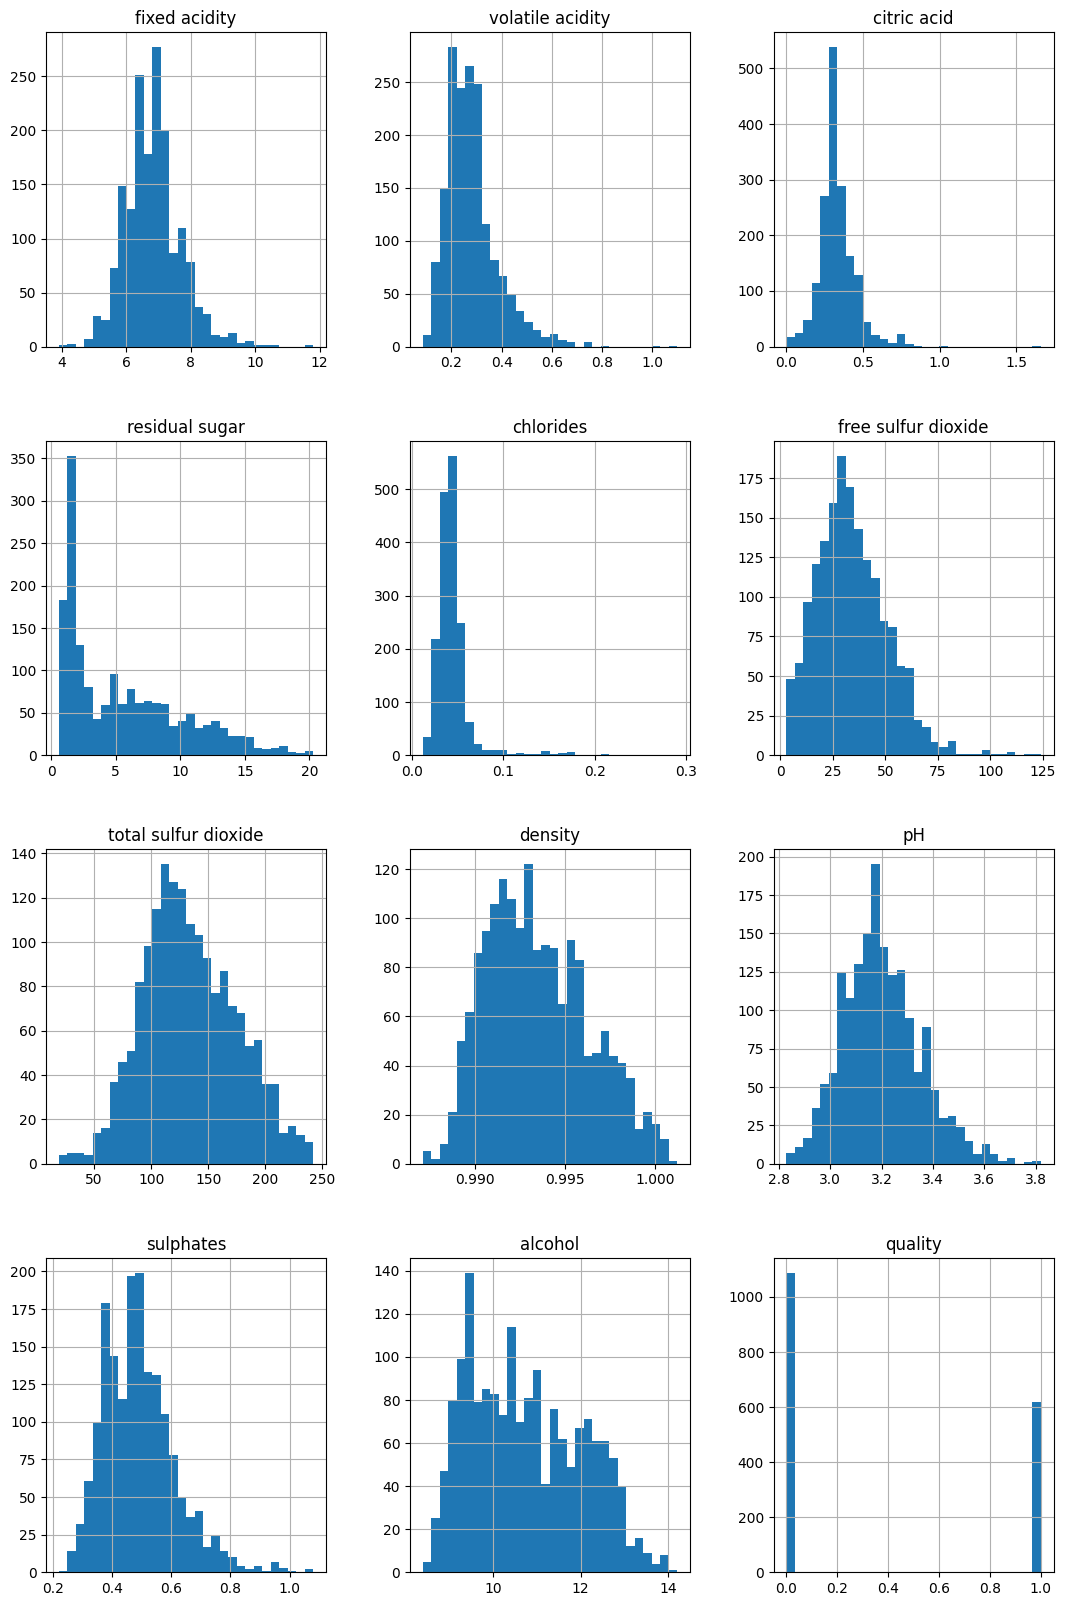

In [62]:
train.hist(bins=30, figsize=(13, 20))
plt.show()

Давайте посмотрим на те признаки, которые имеют приблизительно нормальное распределение, но с небольшим скосом влево. 
Это столбцы ['free sulfur dioxide', 'volatile acidity','residual sugar','chlorides','sulphates']. Их будет полезно пролагорифмировать

In [63]:
# List of columns you want to apply the log1p transformation to
columns_to_transform = ['free sulfur dioxide', 'volatile acidity','residual sugar','chlorides','sulphates']

# Apply np.log1p to the specified columns in both training and testing datasets
train[columns_to_transform] = train[columns_to_transform].apply(np.log1p)

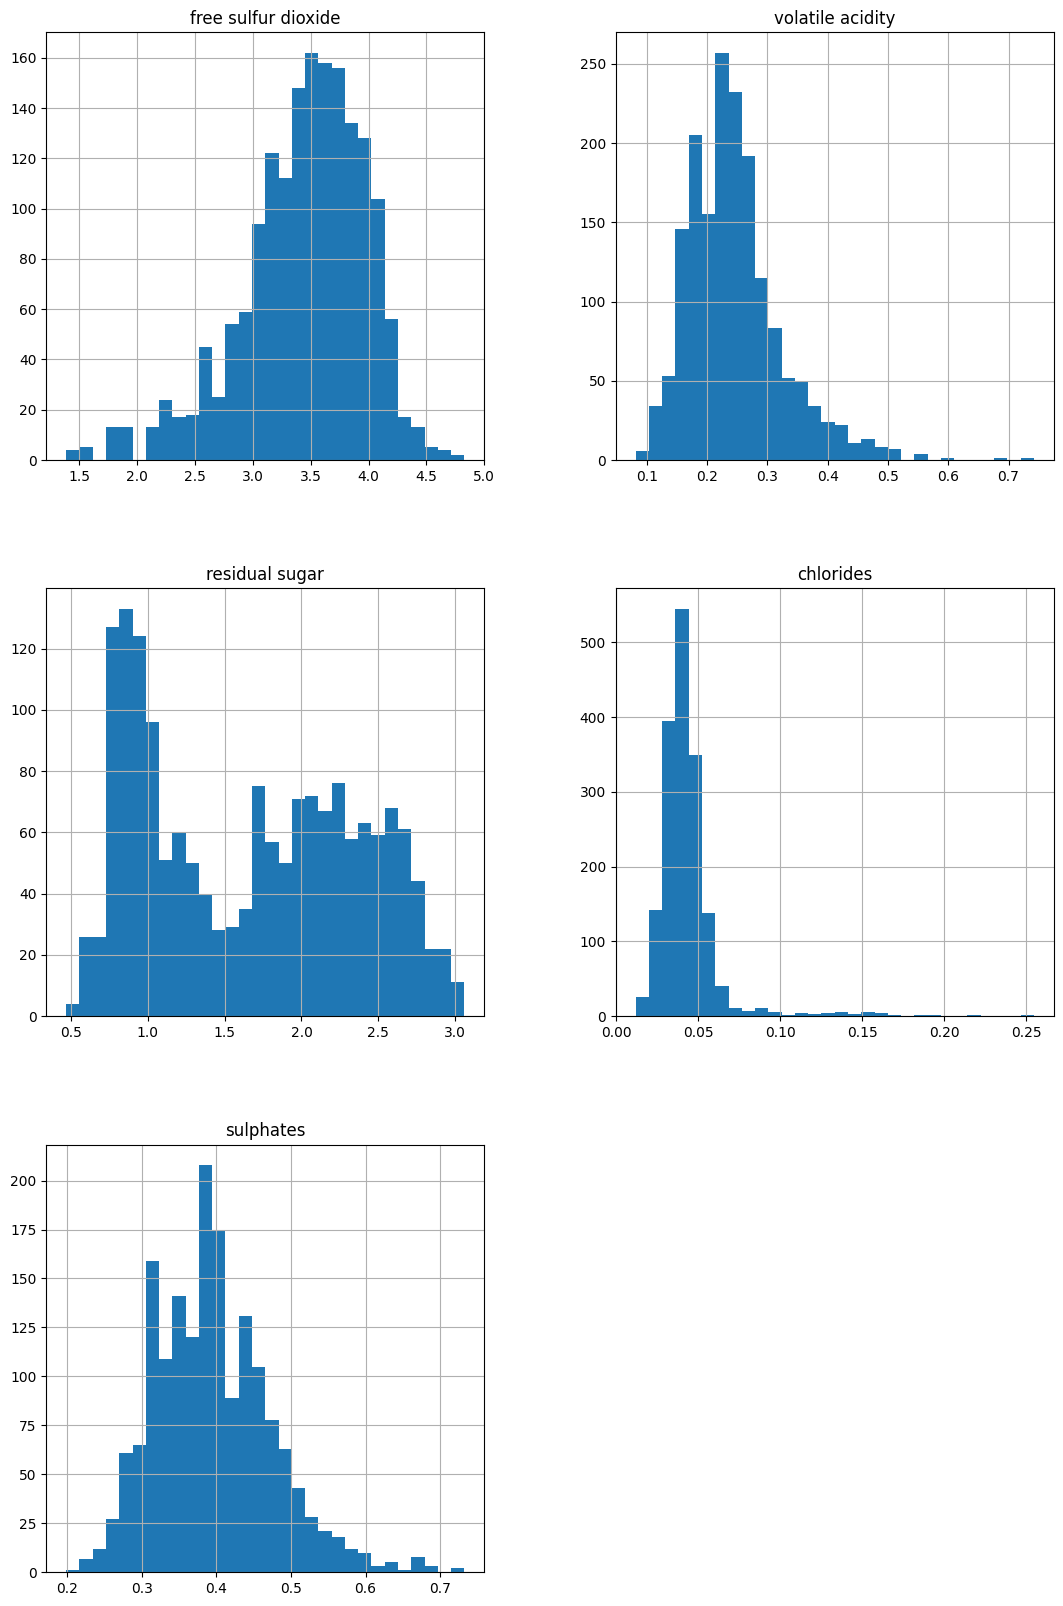

In [64]:
train[['free sulfur dioxide', 'volatile acidity','residual sugar','chlorides','sulphates']].hist(bins=30, figsize=(13, 20))
plt.show()

Видно, что часть столбцов стали более похожими на нормальное распределение. Это поможет нам улучшить скор, т.к. мы перешли к более понятному нормальному распределению

#### Остальные преобразования

Отмечу, что мной было проверено много гипотез, включая удаление некоторых признаков, создание новых признаков и т.д., 
но все они по итогу не привели к улучшению результата, поэтому было принято решение больше не производить преобразований

### Подбор модели

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = 'quality'), train['quality'],
                                                     test_size=0.3)

#### KNN

In [28]:
param_grid = {
    'leaf_size' : np.arange(1,50),
    'n_neighbors': np.arange(1,50),     # Количество соседей
    'weights': ['distance'],  # Веса соседей
    'p': [1]                      
}

In [29]:
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='precision')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'p': [1], 'weights': ['distance']},
             scoring='precision')

In [30]:
grid_search.best_params_

{'leaf_size': 1, 'n_neighbors': 47, 'p': 1, 'weights': 'distance'}

In [31]:
model_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(leaf_size = 1, n_neighbors = 25, p=1, weights='distance'))
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score

print('precision: ', precision_score(y_test,  y_pred))
print('recall:    ', recall_score(y_test,  y_pred))
print('f1:        ', f1_score(y_test,  y_pred))
print('roc_auc_score:', roc_auc_score(y_pred,y_test))

precision:  0.6629213483146067
recall:     0.659217877094972
f1:         0.6610644257703081
roc_auc_score: 0.7401433088878422


In [33]:
# Создайте объект StratifiedKFold с параметром shuffle=True
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Затем передайте этот объект в функцию cross_val_score
cv_scores = cross_val_score(model_knn, X_test, y_test, cv=cv, scoring="precision")

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean Precision = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8000
	0.5000
	0.8571
	0.6667
	0.6522
	0.5500
	0.6000
	0.6190
	0.7222
	0.6190
Mean Precision = 0.6586


Не очень сильное улучшение по сравнению со стандартной моделью

#### Логистическая регрессия

In [34]:
# Создайте список всех возможных комбинаций солверов и штрафов
pipe = Pipeline([('preprocessing', MinMaxScaler()),
('clf', LogisticRegression())])

scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler() ]
param_grid =[
{'preprocessing': scaling,'clf__penalty': ['l2'],
'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'],
'clf__C':  np.arange(1,100, 0.5)},
{'preprocessing': scaling,'clf__penalty': ['l1'],
'clf__solver': ['liblinear'],
'clf__C': np.arange(1,100, 0.5)},
{'preprocessing': scaling,'clf__penalty': ['none'],
'clf__solver': ['lbfgs','newton-cg'],}
]

# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [10,100]
# param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

model = LogisticRegression()
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 4)
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, scoring='precision')


In [35]:
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.698777 using {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'preprocessing': RobustScaler()}


In [36]:
grid_result = pd.DataFrame(grid_result.cv_results_).sort_values(["rank_test_score",'std_test_score'])
grid_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_clf__solver,param_preprocessing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2972,0.012872,0.001675,0.004248,0.000614,1.0,l1,liblinear,RobustScaler(),"{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__so...",0.738095,0.708861,0.648936,0.615385,0.782609,0.698777,0.060189,1
36,0.006811,0.000932,0.003829,0.000396,2.0,l2,liblinear,MinMaxScaler(),"{'clf__C': 2.0, 'clf__penalty': 'l2', 'clf__so...",0.727273,0.727273,0.652174,0.620253,0.765625,0.698520,0.053722,2
2974,0.011156,0.002180,0.004759,0.000479,1.5,l1,liblinear,StandardScaler(),"{'clf__C': 1.5, 'clf__penalty': 'l1', 'clf__so...",0.744186,0.700000,0.648936,0.622222,0.774648,0.697998,0.056853,3
2977,0.012341,0.001183,0.003739,0.000574,2.0,l1,liblinear,StandardScaler(),"{'clf__C': 2.0, 'clf__penalty': 'l1', 'clf__so...",0.744186,0.700000,0.648936,0.622222,0.774648,0.697998,0.056853,3
2978,0.014689,0.001806,0.003955,0.000804,2.0,l1,liblinear,RobustScaler(),"{'clf__C': 2.0, 'clf__penalty': 'l1', 'clf__so...",0.744186,0.700000,0.648936,0.622222,0.774648,0.697998,0.056853,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.021014,0.001990,0.004323,0.000827,6.0,l2,saga,MinMaxScaler(),"{'clf__C': 6.0, 'clf__penalty': 'l2', 'clf__so...",0.703704,0.700000,0.645161,0.607143,0.776119,0.686425,0.057474,3563
120,0.013645,0.001055,0.003579,0.000323,5.0,l2,newton-cg,MinMaxScaler(),"{'clf__C': 5.0, 'clf__penalty': 'l2', 'clf__so...",0.703704,0.700000,0.645161,0.609756,0.772727,0.686270,0.055698,3567
123,0.011212,0.001149,0.003965,0.000793,5.0,l2,lbfgs,MinMaxScaler(),"{'clf__C': 5.0, 'clf__penalty': 'l2', 'clf__so...",0.703704,0.700000,0.645161,0.609756,0.772727,0.686270,0.055698,3567
129,0.011079,0.000769,0.003771,0.000425,5.0,l2,sag,MinMaxScaler(),"{'clf__C': 5.0, 'clf__penalty': 'l2', 'clf__so...",0.703704,0.700000,0.645161,0.609756,0.772727,0.686270,0.055698,3567


In [72]:
best_model = make_pipeline(
                           MinMaxScaler(),
                           LogisticRegression(solver='liblinear',
                                              penalty='l2',
                                              C=1.0, 
                                             ))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [73]:
from sklearn.metrics import recall_score, precision_score, f1_score

print('precision: ', precision_score(y_test,  y_pred))
print('f1:        ', f1_score(y_test,  y_pred))
print('recall:    ', recall_score(y_test,  y_pred))
print('roc_auc_score:', roc_auc_score(y_pred,y_test))

precision:  0.7707006369426752
f1:         0.6836158192090396
recall:     0.6142131979695431
roc_auc_score: 0.7783080649502109


In [80]:
# Создайте объект StratifiedKFold с параметром shuffle=True
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Затем передайте этот объект в функцию cross_val_score
cv_scores = cross_val_score(best_model, X_test, y_test, cv=cv, scoring="precision")

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean Precision = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.6667
	0.6316
	0.7059
	0.6667
	0.8571
	0.7647
	0.9167
	0.6667
	0.7000
	0.8235
Mean Precision = 0.7400


Видим, что на модели Логистической регрессии результат улучшился. Оставим это как финальную